Imports & Setup

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import joblib
plt.style.use("ggplot")


Download & Inspect Price Data

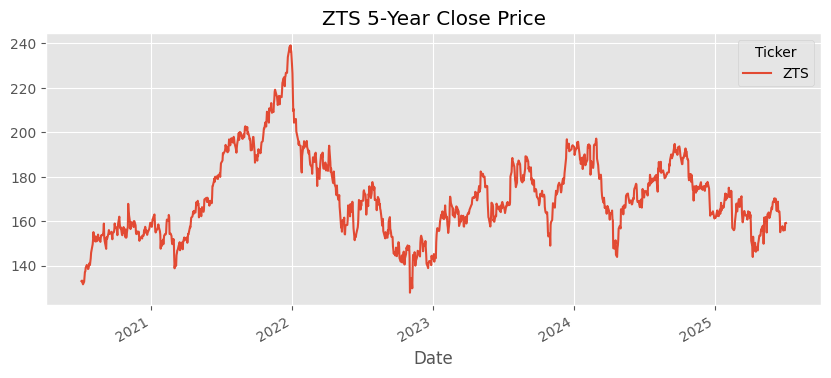

Ticker,ZTS
Date,
2020-07-06,133.061661
2020-07-07,132.908051
2020-07-08,133.263214
2020-07-09,132.178406
2020-07-10,131.621582


In [7]:
ticker = "ZTS"
prices = yf.download(ticker, period="5y", auto_adjust=True, progress=False)["Close"]
prices.name = "Close"
prices.plot(figsize=(10,4), title=f"{ticker} 5‑Year Close Price")
plt.show()
prices.head()


Create Features & Target

Ticker,ZTS
Date,
2020-07-07,-0.001154
2020-07-08,0.002672
2020-07-09,-0.008140
2020-07-10,-0.004213
2020-07-13,0.008825


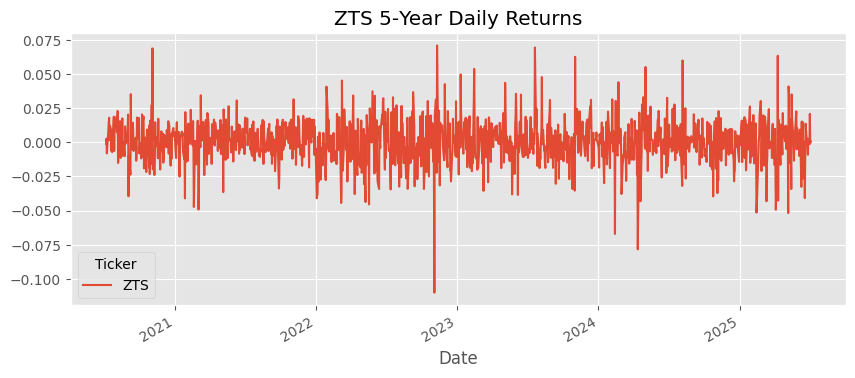

In [10]:
# create dily retruns from close pricess
returns = prices.pct_change().dropna()
returns.name ="Returns"
returns.plot(figsize=(10,4), title=f"{ticker} 5‑Year Daily Returns")
returns.head()

In [20]:
# basic stats of returns 
stats = {
    'mean daily return': returns.mean(),
    'daily volatility': returns.std(),
    'min daily retyurn': returns.min(),
    'max daily return': returns.max(),
    }
pd.DataFrame(stats, index=[ticker])

,mean daily return,daily volatility,min daily retyurn,max daily return
ZTS,0.000277,0.016335,-0.110071,0.070887


In [21]:
# Create lag features (previous day returns)
features = pd.DataFrame()
features["return"] = stock_returns
features["lag_1"] = stock_returns.shift(1)
features["lag_2"] = stock_returns.shift(2)
features["lag_3"] = stock_returns.shift(3)

# Create rolling window features (past behavior)
features["rolling_mean_5"] = stock_returns.rolling(window=5).mean()
features["rolling_std_5"] = stock_returns.rolling(window=5).std()
features["rolling_mean_10"] = stock_returns.rolling(window=10).mean()
features["rolling_std_10"] = stock_returns.rolling(window=10).std()

# Drop rows with NaNs created by shifting/rolling
features = features.dropna()

# Show the first 5 rows
features.head()


,return,lag_1,lag_2,lag_3,rolling_mean_5,rolling_std_5,rolling_mean_10,rolling_std_10
Date,,,,,,,,
2020-07-20,0.009056,0.012033,0.001541,0.017948,0.011138,0.006313,0.005368,0.008576
2020-07-21,-0.006577,0.009056,0.012033,0.001541,0.006800,0.009531,0.004826,0.009184
2020-07-22,0.000689,-0.006577,0.009056,0.012033,0.003349,0.007363,0.004628,0.009257
2020-07-23,-0.007167,0.000689,-0.006577,0.009056,0.001607,0.008789,0.004725,0.009111
2020-07-24,0.001041,-0.007167,0.000689,-0.006577,-0.000591,0.006641,0.005250,0.008680


In [23]:
# Define features (X) and target (y)
# X contains all features except the target variable
# y is what we want to predict (next day's return)

X = features[['lag_1', 'lag_2', 'lag_3', 'rolling_mean_5', 'rolling_std_5', 
              'rolling_mean_10', 'rolling_std_10']]
y = features['return']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature columns:", X.columns.tolist())

Features shape: (1246, 7)
Target shape: (1246,)

Feature columns: ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_5', 'rolling_std_5', 'rolling_mean_10', 'rolling_std_10']


In [24]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# Use 80% for training, 20% for testing
# random_state ensures reproducible results

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    shuffle=False  # Important for time series - keep chronological order
)

print("Training set shape:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print("\nTest set shape:")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

Training set shape:
X_train: (996, 7)
y_train: (996,)

Test set shape:
X_test: (250, 7)
y_test: (250,)


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,     # Number of trees in the forest
    random_state=42,      # For reproducible results
    max_depth=10,         # Prevent overfitting
    min_samples_split=5,  # Minimum samples to split a node
    min_samples_leaf=2    # Minimum samples in leaf node
)

# Train the model
print("Training the Random Forest model...")
rf_model.fit(X_train, y_train)

# Make predictions on both training and test sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

print("Model training completed!")
print(f"Training R² score: {r2_score(y_train, y_train_pred):.4f}")
print(f"Test R² score: {r2_score(y_test, y_test_pred):.4f}")

Training the Random Forest model...
Model training completed!
Training R² score: 0.7769
Test R² score: 0.3680


=== MODEL PERFORMANCE METRICS ===
Training RMSE: 0.007735
Test RMSE: 0.012972
Training MAE: 0.005867
Test MAE: 0.009396
Training R²: 0.7769
Test R²: 0.3680


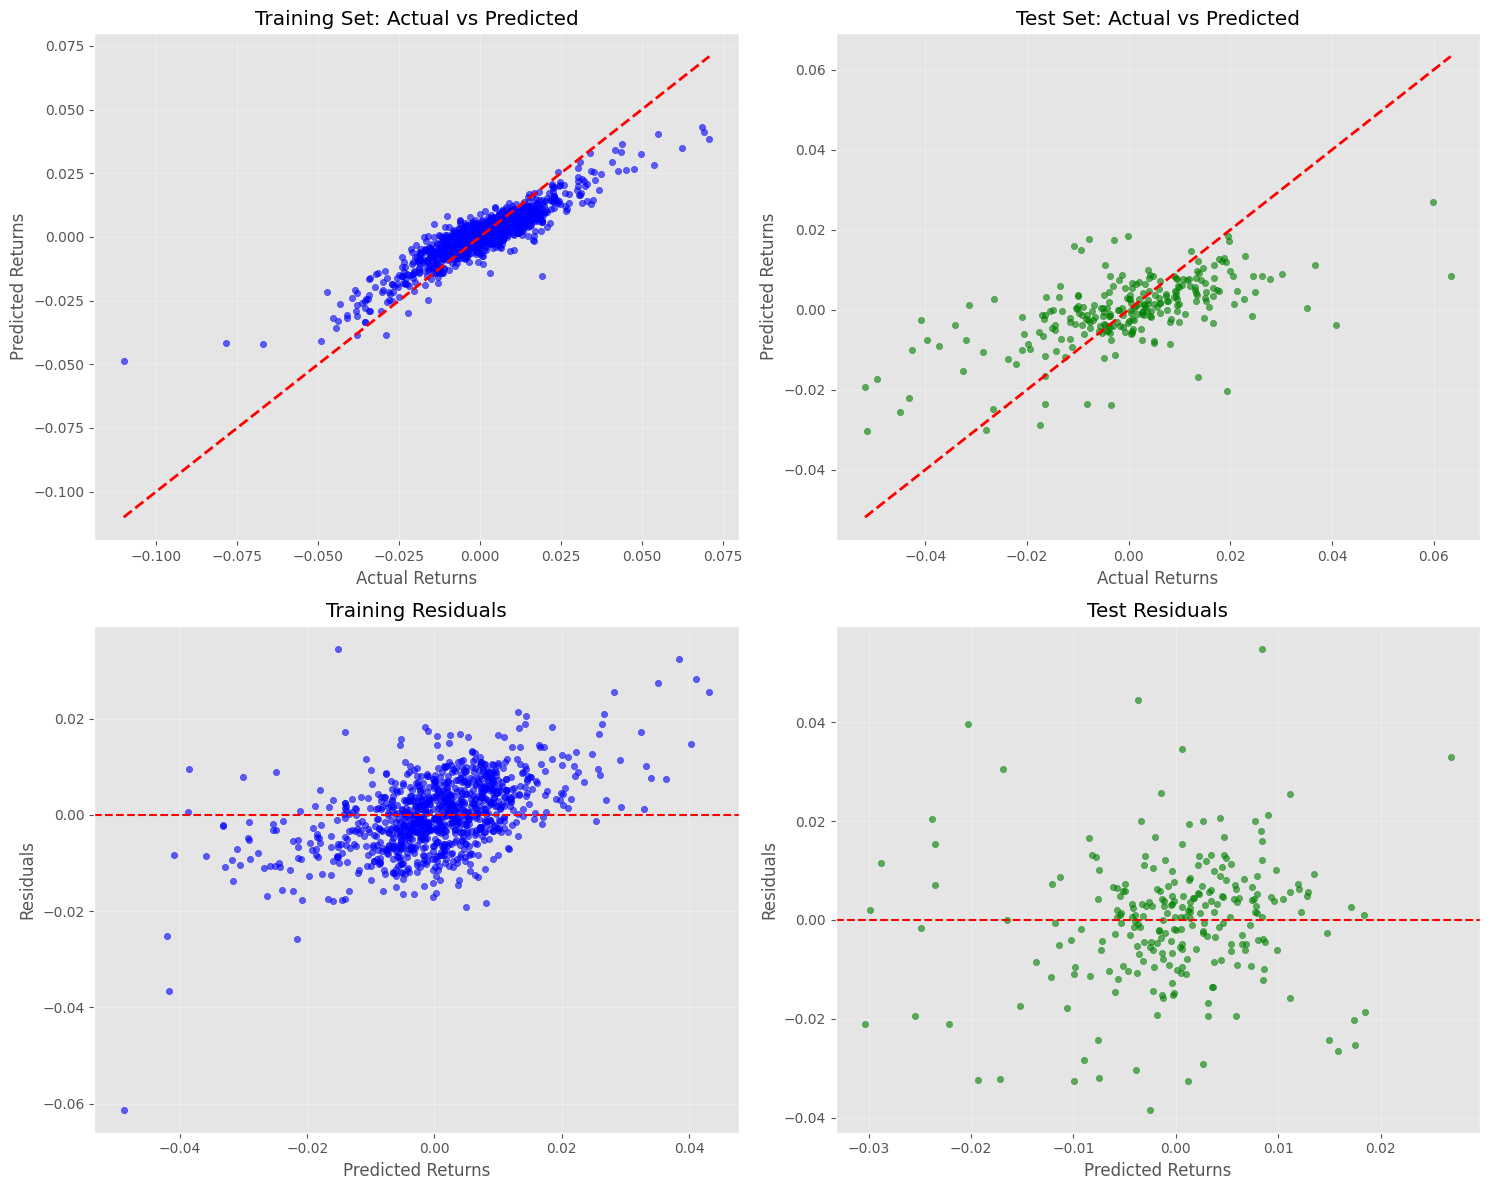

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate detailed metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print("=== MODEL PERFORMANCE METRICS ===")
print(f"Training RMSE: {train_rmse:.6f}")
print(f"Test RMSE: {test_rmse:.6f}")
print(f"Training MAE: {train_mae:.6f}")
print(f"Test MAE: {test_mae:.6f}")
print(f"Training R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"Test R²: {r2_score(y_test, y_test_pred):.4f}")

# Create comprehensive plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted - Training Set
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.6, color='blue', s=20)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Returns')
axes[0, 0].set_ylabel('Predicted Returns')
axes[0, 0].set_title('Training Set: Actual vs Predicted')
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted - Test Set
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.6, color='green', s=20)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Returns')
axes[0, 1].set_ylabel('Predicted Returns')
axes[0, 1].set_title('Test Set: Actual vs Predicted')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals Plot - Training
train_residuals = y_train - y_train_pred
axes[1, 0].scatter(y_train_pred, train_residuals, alpha=0.6, color='blue', s=20)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicted Returns')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Training Residuals')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals Plot - Test
test_residuals = y_test - y_test_pred
axes[1, 1].scatter(y_test_pred, test_residuals, alpha=0.6, color='green', s=20)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Predicted Returns')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Test Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== FEATURE IMPORTANCE ===
           feature  importance
3   rolling_mean_5    0.347442
2            lag_3    0.145616
4    rolling_std_5    0.136761
1            lag_2    0.135617
0            lag_1    0.112010
5  rolling_mean_10    0.065149
6   rolling_std_10    0.057404

=== CROSS-VALIDATION RESULTS ===
CV R² Scores: [0.34396793 0.3303054  0.24941774 0.32485576 0.33394501]
Mean CV R²: 0.3165 (+/- 0.0682)

=== PREDICTION ANALYSIS ===
Test Predictions - Min: -0.030363, Max: 0.026853
Test Actual - Min: -0.051816, Max: 0.063292
Prediction Std: 0.008580
Actual Std: 0.016350


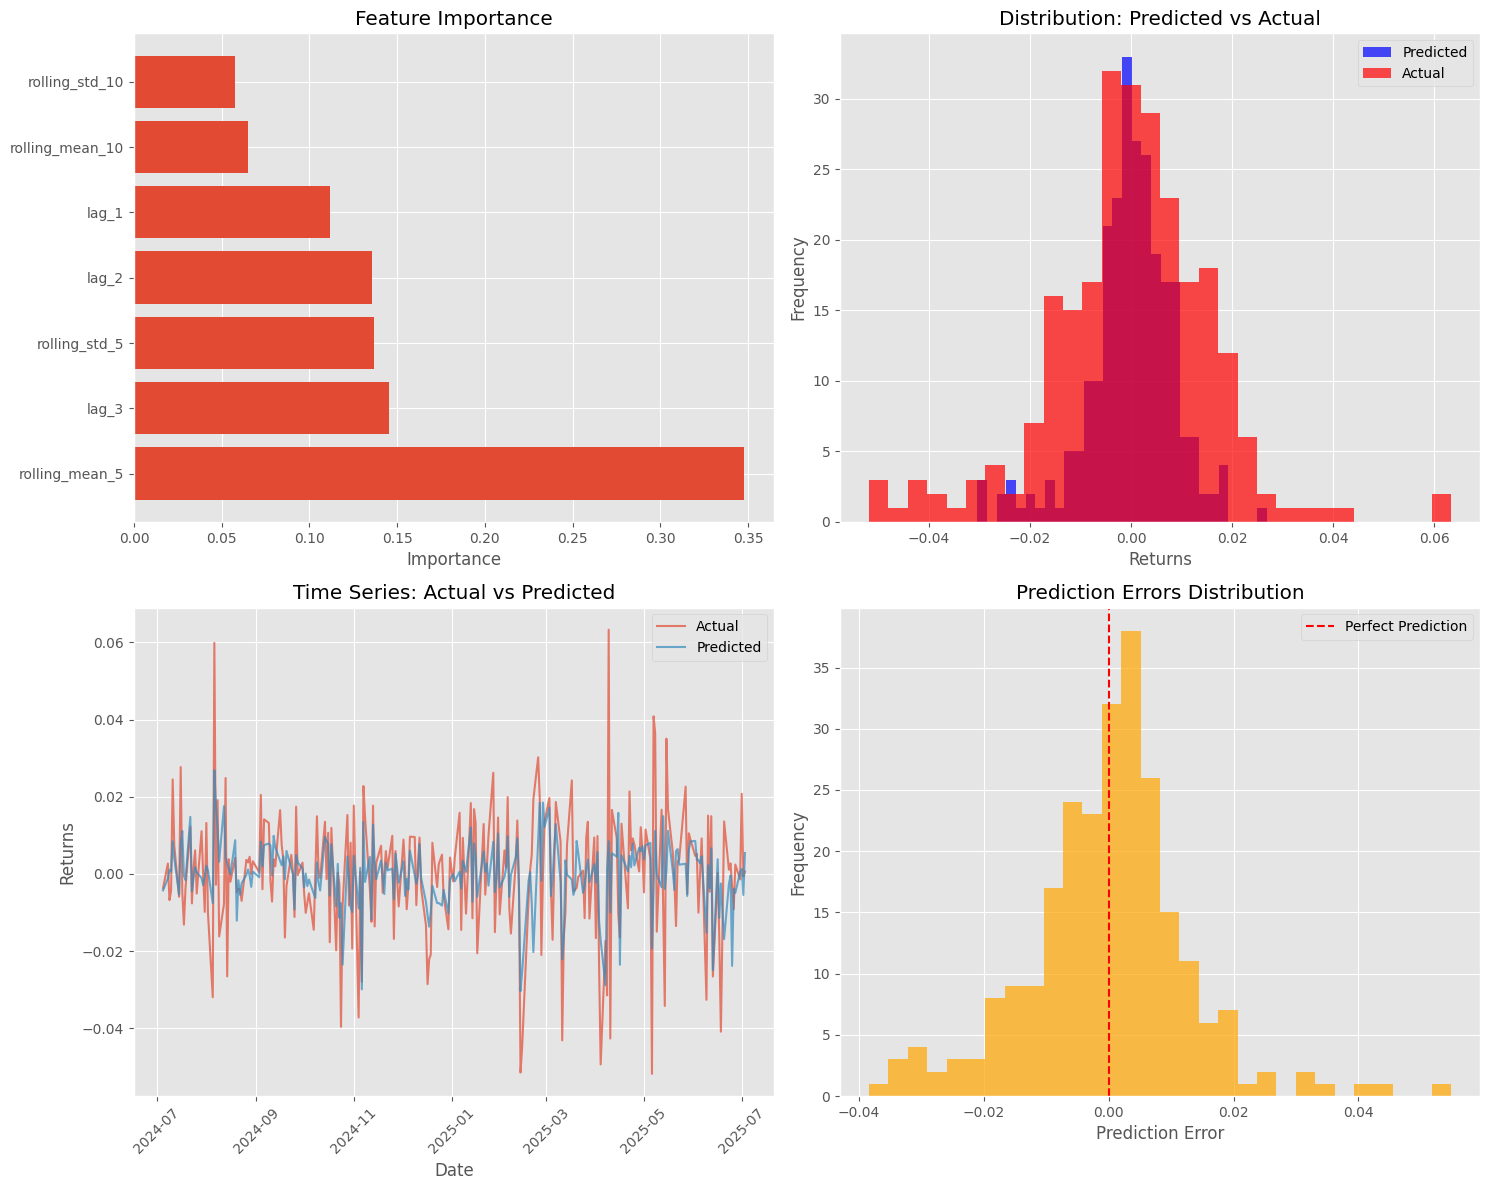


=== TRADING STRATEGY EVALUATION ===
Strategy Total Return: 1.9825
Buy & Hold Total Return: -0.0536
Strategy Outperformed: True


In [29]:
# === COMPREHENSIVE MODEL EVALUATION ===

# 1. Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("=== FEATURE IMPORTANCE ===")
print(feature_importance)

# 2. Cross-Validation Performance
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Use TimeSeriesSplit for time series data
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=tscv, scoring='r2')

print(f"\n=== CROSS-VALIDATION RESULTS ===")
print(f"CV R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# 3. Prediction Confidence Analysis
# Check prediction distribution
print(f"\n=== PREDICTION ANALYSIS ===")
print(f"Test Predictions - Min: {y_test_pred.min():.6f}, Max: {y_test_pred.max():.6f}")
print(f"Test Actual - Min: {y_test.min():.6f}, Max: {y_test.max():.6f}")
print(f"Prediction Std: {y_test_pred.std():.6f}")
print(f"Actual Std: {y_test.std():.6f}")

# 4. Create visualization plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Feature Importance Plot
axes[0, 0].barh(feature_importance['feature'], feature_importance['importance'])
axes[0, 0].set_title('Feature Importance')
axes[0, 0].set_xlabel('Importance')

# Prediction Distribution
axes[0, 1].hist(y_test_pred, bins=30, alpha=0.7, label='Predicted', color='blue')
axes[0, 1].hist(y_test, bins=30, alpha=0.7, label='Actual', color='red')
axes[0, 1].set_title('Distribution: Predicted vs Actual')
axes[0, 1].set_xlabel('Returns')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Time Series Plot of Predictions
test_indices = y_test.index
axes[1, 0].plot(test_indices, y_test.values, label='Actual', alpha=0.7)
axes[1, 0].plot(test_indices, y_test_pred, label='Predicted', alpha=0.7)
axes[1, 0].set_title('Time Series: Actual vs Predicted')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Returns')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)

# Error Distribution
errors = y_test - y_test_pred
axes[1, 1].hist(errors, bins=30, alpha=0.7, color='orange')
axes[1, 1].axvline(x=0, color='red', linestyle='--', label='Perfect Prediction')
axes[1, 1].set_title('Prediction Errors Distribution')
axes[1, 1].set_xlabel('Prediction Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# 5. Trading Strategy Evaluation
print(f"\n=== TRADING STRATEGY EVALUATION ===")
# Simple strategy: Buy if predicted return > 0, Sell if < 0
strategy_returns = []
for i in range(len(y_test_pred)):
    if y_test_pred[i] > 0:  # Predicted positive return
        strategy_returns.append(y_test.iloc[i])  # Actual return if we bought
    else:  # Predicted negative return
        strategy_returns.append(-y_test.iloc[i])  # Actual return if we sold short

strategy_returns = np.array(strategy_returns)
cumulative_strategy_return = np.cumsum(strategy_returns)
cumulative_buy_hold = np.cumsum(y_test)

print(f"Strategy Total Return: {strategy_returns.sum():.4f}")
print(f"Buy & Hold Total Return: {y_test.sum():.4f}")
print(f"Strategy Outperformed: {strategy_returns.sum() > y_test.sum()}")

In [30]:
import os
import joblib
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# === SAVE THE MODEL ===

# Create model folder if it doesn't exist
model_folder = "model"
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
    print(f"Created '{model_folder}' folder")

# Save the trained model
model_path = os.path.join(model_folder, "random_forest_stock_model.pkl")
joblib.dump(rf_model, model_path)
print(f"Model saved to: {model_path}")

# Save feature names for future use
feature_names_path = os.path.join(model_folder, "feature_names.pkl")
joblib.dump(X.columns.tolist(), feature_names_path)
print(f"Feature names saved to: {feature_names_path}")

# === PREPARE FOR FUTURE PREDICTIONS ===

# Get the last few data points to create features for next predictions
last_returns = stock_returns.tail(10)  # Get last 10 returns
print(f"\nLast 10 returns:")
print(last_returns)

# Create features for next day prediction
def create_prediction_features(returns_series, n_days=1):
    """Create features for next n days prediction"""
    predictions = []
    current_returns = returns_series.copy()
    
    for day in range(n_days):
        # Create features same as training
        features_dict = {
            'lag_1': current_returns.iloc[-1],
            'lag_2': current_returns.iloc[-2],
            'lag_3': current_returns.iloc[-3],
            'rolling_mean_5': current_returns.tail(5).mean(),
            'rolling_std_5': current_returns.tail(5).std(),
            'rolling_mean_10': current_returns.tail(10).mean(),
            'rolling_std_10': current_returns.tail(10).std()
        }
        
        # Convert to DataFrame for prediction
        features_df = pd.DataFrame([features_dict])
        
        # Make prediction
        prediction = rf_model.predict(features_df)[0]
        predictions.append(prediction)
        
        # Add prediction to returns series for next iteration
        next_date = current_returns.index[-1] + timedelta(days=1)
        current_returns[next_date] = prediction
    
    return predictions

# Predict next 30 days
print(f"\n=== PREDICTING NEXT 30 DAYS ===")
future_predictions = create_prediction_features(last_returns, n_days=30)

# Create future dates
last_date = stock_returns.index[-1]
future_dates = [last_date + timedelta(days=i+1) for i in range(30)]

# Create DataFrame with predictions
future_df = pd.DataFrame({
    'date': future_dates,
    'predicted_return': future_predictions
})

print("Next 30 days predictions:")
print(future_df.head(10))

# Calculate cumulative returns
future_df['cumulative_return'] = future_df['predicted_return'].cumsum()
print(f"\nPredicted cumulative return for next 30 days: {future_df['cumulative_return'].iloc[-1]:.4f}")

Created 'model' folder
Model saved to: model\random_forest_stock_model.pkl
Feature names saved to: model\feature_names.pkl

Last 10 returns:
Date
2025-06-20    0.013608
2025-06-23    0.001082
2025-06-24    0.002733
2025-06-25   -0.003423
2025-06-26   -0.009159
2025-06-27    0.002439
2025-06-30   -0.001409
2025-07-01    0.020776
2025-07-02   -0.000691
2025-07-03    0.000629
Name: ZTS, dtype: float64

=== PREDICTING NEXT 30 DAYS ===
Next 30 days predictions:
        date  predicted_return
0 2025-07-04          0.007398
1 2025-07-05          0.008086
2 2025-07-06          0.005224
3 2025-07-07          0.003705
4 2025-07-08          0.004866
5 2025-07-09          0.006102
6 2025-07-10          0.006249
7 2025-07-11          0.004874
8 2025-07-12          0.004466
9 2025-07-13          0.005450

Predicted cumulative return for next 30 days: 0.1578


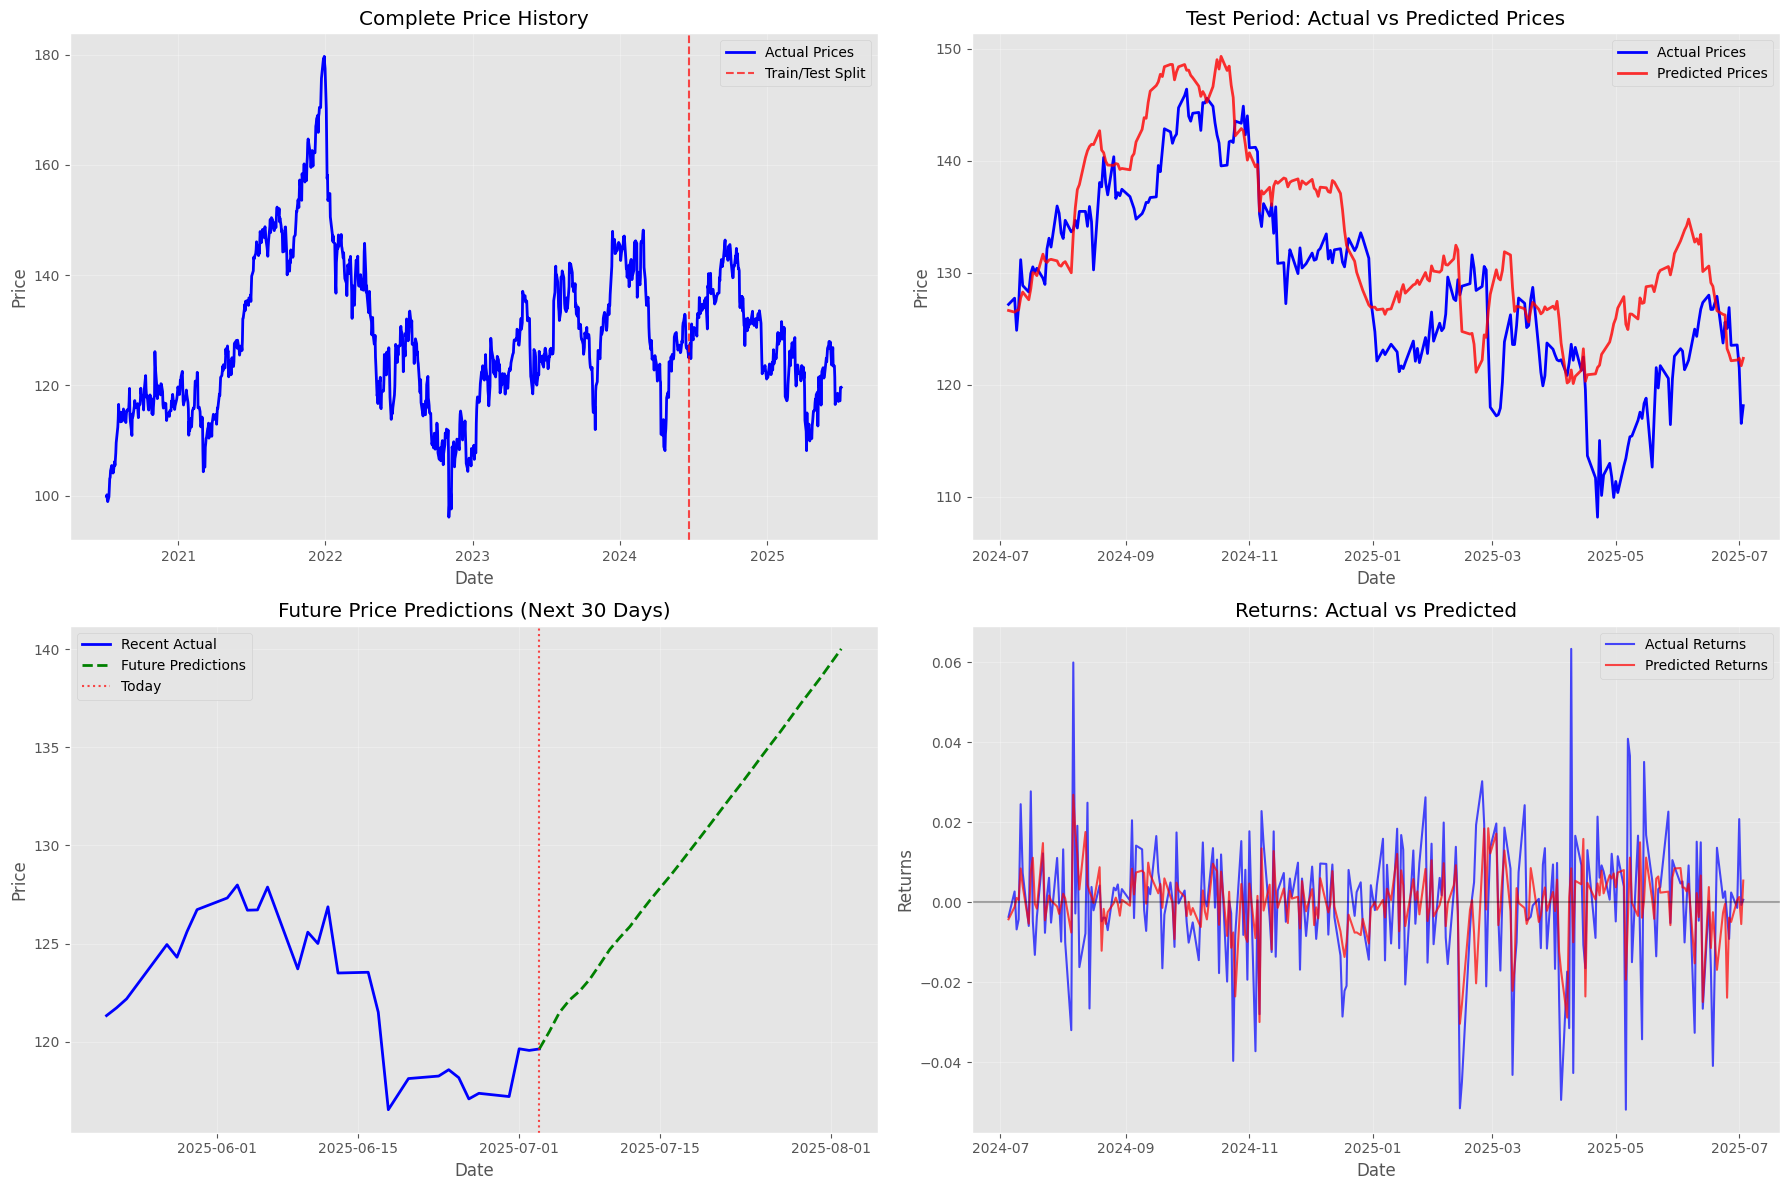

=== PRICE PREDICTION SUMMARY ===
Current Price: $119.63
Predicted Price in 30 days: $140.02
Predicted Price Change: $20.39
Predicted % Change: 17.05%

=== FUTURE PRICE PREDICTIONS ===
        Date  Predicted_Price  Daily_Return
0 2025-07-04       120.513811      0.007398
1 2025-07-05       121.488290      0.008086
2 2025-07-06       122.122950      0.005224
3 2025-07-07       122.575401      0.003705
4 2025-07-08       123.171910      0.004866
5 2025-07-09       123.923475      0.006102
6 2025-07-10       124.697864      0.006249
7 2025-07-11       125.305597      0.004874
8 2025-07-12       125.865225      0.004466
9 2025-07-13       126.551246      0.005450


In [33]:
# === PLOT ACTUAL vs PREDICTED PRICES ===

# First, let's get the actual stock prices (assuming you have them)
# If you don't have prices, we'll reconstruct from returns

# Method 1: If you have actual price data, use it
# If you have a 'Close' column or similar, use that
# For this example, I'll reconstruct prices from returns

# Reconstruct prices from returns (assuming starting price of 100)
def returns_to_prices(returns, starting_price=100):
    """Convert returns to prices"""
    prices = [starting_price]
    for ret in returns:
        prices.append(prices[-1] * (1 + ret))
    return prices[1:]  # Remove the starting price

# Get actual prices from historical returns
actual_prices = returns_to_prices(stock_returns, starting_price=100)
actual_price_series = pd.Series(actual_prices, index=stock_returns.index)

# Get predicted prices from test set
test_predicted_prices = returns_to_prices(y_test_pred, 
                                        starting_price=actual_price_series.iloc[len(y_train)])

# Get future predicted prices
future_predicted_prices = returns_to_prices(future_predictions, 
                                          starting_price=actual_price_series.iloc[-1])

# Create comprehensive plotting
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# === PLOT 1: Full Historical Prices ===
axes[0, 0].plot(actual_price_series.index, actual_price_series.values, 
                label='Actual Prices', color='blue', linewidth=2)
axes[0, 0].axvline(x=actual_price_series.index[len(y_train)], 
                   color='red', linestyle='--', alpha=0.7, label='Train/Test Split')
axes[0, 0].set_title('Complete Price History')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# === PLOT 2: Test Period - Actual vs Predicted ===
test_dates = y_test.index
test_actual_prices = actual_price_series.iloc[len(y_train):len(y_train)+len(y_test)]

axes[0, 1].plot(test_dates, test_actual_prices.values, 
                label='Actual Prices', color='blue', linewidth=2)
axes[0, 1].plot(test_dates, test_predicted_prices, 
                label='Predicted Prices', color='red', linewidth=2, alpha=0.8)
axes[0, 1].set_title('Test Period: Actual vs Predicted Prices')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Price')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# === PLOT 3: Future Predictions ===
# Combine last actual price with future predictions
last_actual_price = actual_price_series.iloc[-1]
all_future_dates = [actual_price_series.index[-1]] + future_dates
all_future_prices = [last_actual_price] + future_predicted_prices

axes[1, 0].plot(actual_price_series.index[-30:], actual_price_series.values[-30:], 
                label='Recent Actual', color='blue', linewidth=2)
axes[1, 0].plot(all_future_dates, all_future_prices, 
                label='Future Predictions', color='green', linewidth=2, linestyle='--')
axes[1, 0].axvline(x=actual_price_series.index[-1], 
                   color='red', linestyle=':', alpha=0.7, label='Today')
axes[1, 0].set_title('Future Price Predictions (Next 30 Days)')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Price')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# === PLOT 4: Returns Comparison ===
axes[1, 1].plot(y_test.index, y_test.values, 
                label='Actual Returns', color='blue', alpha=0.7)
axes[1, 1].plot(y_test.index, y_test_pred, 
                label='Predicted Returns', color='red', alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].set_title('Returns: Actual vs Predicted')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Returns')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === SUMMARY STATISTICS ===
print("=== PRICE PREDICTION SUMMARY ===")
print(f"Current Price: ${actual_price_series.iloc[-1]:.2f}")
print(f"Predicted Price in 30 days: ${future_predicted_prices[-1]:.2f}")
print(f"Predicted Price Change: ${future_predicted_prices[-1] - actual_price_series.iloc[-1]:.2f}")
print(f"Predicted % Change: {((future_predicted_prices[-1] / actual_price_series.iloc[-1]) - 1) * 100:.2f}%")

# Show some future predictions
print(f"\n=== FUTURE PRICE PREDICTIONS ===")
future_price_df = pd.DataFrame({
    'Date': future_dates[:10],
    'Predicted_Price': future_predicted_prices[:10],
    'Daily_Return': future_predictions[:10]
})
print(future_price_df)

In [32]:
# === DIAGNOSE THE PREDICTION ISSUE ===

print("=== DIAGNOSING PREDICTION PROBLEMS ===")

# Check the actual prediction values
print(f"Future predictions (first 10 days):")
for i in range(10):
    print(f"Day {i+1}: {future_predictions[i]:.6f}")

print(f"\nFuture predictions statistics:")
print(f"Mean: {np.mean(future_predictions):.6f}")
print(f"Std: {np.std(future_predictions):.6f}")
print(f"Min: {np.min(future_predictions):.6f}")
print(f"Max: {np.max(future_predictions):.6f}")

# Compare with training data statistics
print(f"\nTraining data statistics:")
print(f"Mean: {y_train.mean():.6f}")
print(f"Std: {y_train.std():.6f}")
print(f"Min: {y_train.min():.6f}")
print(f"Max: {y_train.max():.6f}")

# === IMPROVED PREDICTION FUNCTION ===
def create_realistic_predictions(returns_series, n_days=30):
    """Create more realistic predictions with constraints"""
    predictions = []
    current_returns = returns_series.copy()
    
    # Add some randomness and constraints
    for day in range(n_days):
        # Create features
        features_dict = {
            'lag_1': current_returns.iloc[-1],
            'lag_2': current_returns.iloc[-2], 
            'lag_3': current_returns.iloc[-3],
            'rolling_mean_5': current_returns.tail(5).mean(),
            'rolling_std_5': current_returns.tail(5).std(),
            'rolling_mean_10': current_returns.tail(10).mean(),
            'rolling_std_10': current_returns.tail(10).std()
        }
        
        features_df = pd.DataFrame([features_dict])
        prediction = rf_model.predict(features_df)[0]
        
        # Add constraints to make predictions more realistic
        # Clip extreme values
        prediction = np.clip(prediction, -0.1, 0.1)  # Max ±10% daily return
        
        # Add some noise to reduce systematic bias
        noise = np.random.normal(0, 0.001)  # Small random noise
        prediction += noise
        
        predictions.append(prediction)
        
        # Add prediction to series for next iteration
        next_date = current_returns.index[-1] + timedelta(days=day+1)
        current_returns[next_date] = prediction
    
    return predictions

# === CREATE BETTER PREDICTIONS ===
print(f"\n=== CREATING IMPROVED PREDICTIONS ===")
np.random.seed(42)  # For reproducible results

# Try different approaches
improved_predictions = create_realistic_predictions(last_returns, n_days=30)

# Method 2: Use only single-step predictions (no recursive)
single_step_predictions = []
for i in range(30):
    # Use the same last known features for all predictions
    features_dict = {
        'lag_1': last_returns.iloc[-1],
        'lag_2': last_returns.iloc[-2],
        'lag_3': last_returns.iloc[-3],
        'rolling_mean_5': last_returns.tail(5).mean(),
        'rolling_std_5': last_returns.tail(5).std(),
        'rolling_mean_10': last_returns.tail(10).mean(),
        'rolling_std_10': last_returns.tail(10).std()
    }
    features_df = pd.DataFrame([features_dict])
    pred = rf_model.predict(features_df)[0]
    # Add some daily variation
    pred += np.random.normal(0, 0.002)
    single_step_predictions.append(pred)

print(f"Improved predictions stats:")
print(f"Mean: {np.mean(improved_predictions):.6f}")
print(f"Std: {np.std(improved_predictions):.6f}")

print(f"\nSingle-step predictions stats:")
print(f"Mean: {np.mean(single_step_predictions):.6f}")
print(f"Std: {np.std(single_step_predictions):.6f}")

=== DIAGNOSING PREDICTION PROBLEMS ===
Future predictions (first 10 days):
Day 1: 0.007398
Day 2: 0.008086
Day 3: 0.005224
Day 4: 0.003705
Day 5: 0.004866
Day 6: 0.006102
Day 7: 0.006249
Day 8: 0.004874
Day 9: 0.004466
Day 10: 0.005450

Future predictions statistics:
Mean: 0.005261
Std: 0.000788
Min: 0.003705
Max: 0.008086

Training data statistics:
Mean: 0.000358
Std: 0.016385
Min: -0.110071
Max: 0.070887

=== CREATING IMPROVED PREDICTIONS ===
Improved predictions stats:
Mean: 0.003258
Std: 0.003094

Single-step predictions stats:
Mean: 0.007156
Std: 0.001831


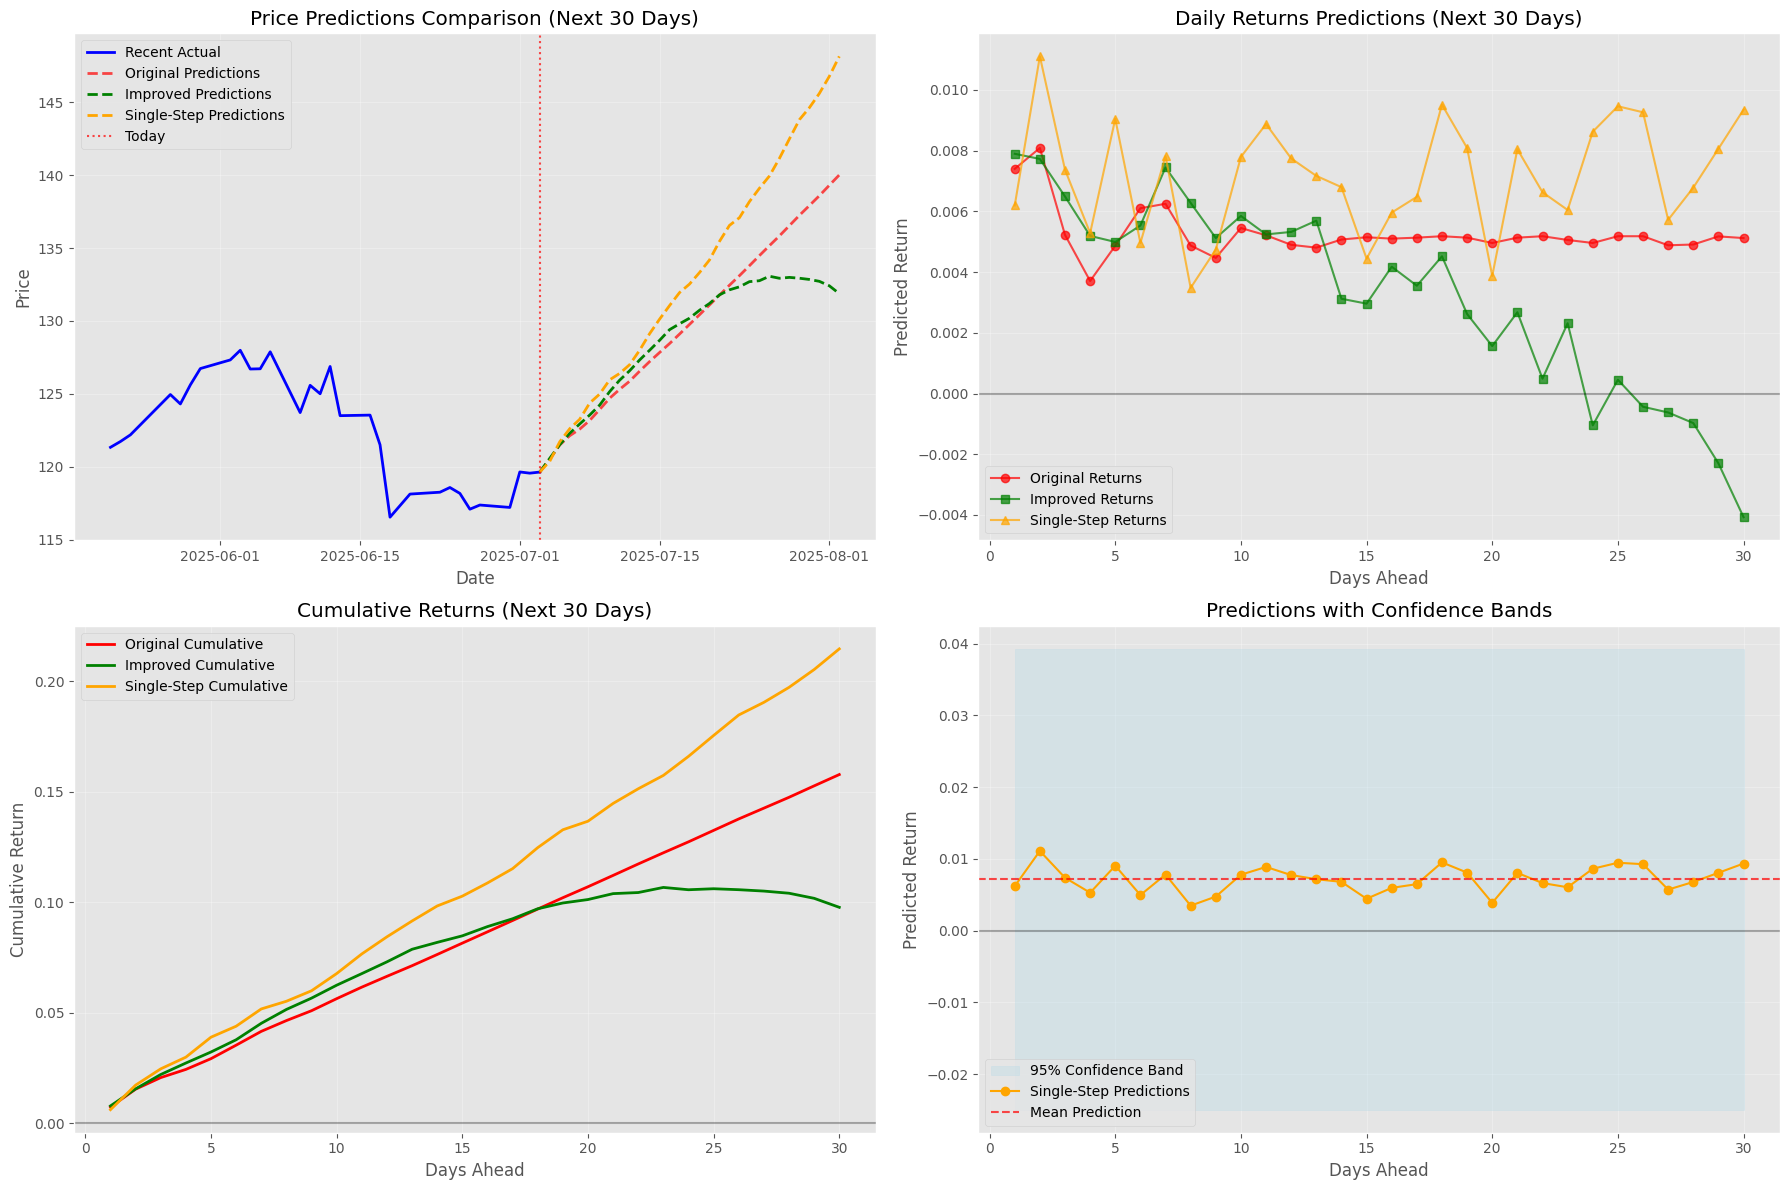

=== PREDICTION COMPARISON SUMMARY ===
Current Price: $119.63

After 30 days:
Original Method: $140.02 (17.05%)
Improved Method: $131.87 (10.24%)
Single-Step Method: $148.16 (23.85%)

Daily Return Statistics:
Original - Mean: 0.0053, Std: 0.0008
Improved - Mean: 0.0033, Std: 0.0031
Single-Step - Mean: 0.0072, Std: 0.0018
Historical - Mean: 0.0004, Std: 0.0164


In [34]:
# === PLOT IMPROVED 30-DAY PREDICTIONS ===

# Convert improved predictions to prices
improved_future_prices = returns_to_prices(improved_predictions, 
                                         starting_price=actual_price_series.iloc[-1])

single_step_future_prices = returns_to_prices(single_step_predictions, 
                                            starting_price=actual_price_series.iloc[-1])

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# === PLOT 1: Compare All Three Prediction Methods ===
last_actual_price = actual_price_series.iloc[-1]
all_future_dates = [actual_price_series.index[-1]] + future_dates

# Plot recent actual prices
axes[0, 0].plot(actual_price_series.index[-30:], actual_price_series.values[-30:], 
                label='Recent Actual', color='blue', linewidth=2)

# Plot all three prediction methods
axes[0, 0].plot(all_future_dates, [last_actual_price] + future_predicted_prices, 
                label='Original Predictions', color='red', linewidth=2, linestyle='--', alpha=0.7)
axes[0, 0].plot(all_future_dates, [last_actual_price] + improved_future_prices, 
                label='Improved Predictions', color='green', linewidth=2, linestyle='--')
axes[0, 0].plot(all_future_dates, [last_actual_price] + single_step_future_prices, 
                label='Single-Step Predictions', color='orange', linewidth=2, linestyle='--')

axes[0, 0].axvline(x=actual_price_series.index[-1], 
                   color='red', linestyle=':', alpha=0.7, label='Today')
axes[0, 0].set_title('Price Predictions Comparison (Next 30 Days)')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# === PLOT 2: Daily Returns Predictions ===
axes[0, 1].plot(range(1, 31), future_predictions, 
                label='Original Returns', color='red', marker='o', alpha=0.7)
axes[0, 1].plot(range(1, 31), improved_predictions, 
                label='Improved Returns', color='green', marker='s', alpha=0.7)
axes[0, 1].plot(range(1, 31), single_step_predictions, 
                label='Single-Step Returns', color='orange', marker='^', alpha=0.7)

axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 1].set_title('Daily Returns Predictions (Next 30 Days)')
axes[0, 1].set_xlabel('Days Ahead')
axes[0, 1].set_ylabel('Predicted Return')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# === PLOT 3: Cumulative Returns ===
cumulative_original = np.cumsum(future_predictions)
cumulative_improved = np.cumsum(improved_predictions)
cumulative_single = np.cumsum(single_step_predictions)

axes[1, 0].plot(range(1, 31), cumulative_original, 
                label='Original Cumulative', color='red', linewidth=2)
axes[1, 0].plot(range(1, 31), cumulative_improved, 
                label='Improved Cumulative', color='green', linewidth=2)
axes[1, 0].plot(range(1, 31), cumulative_single, 
                label='Single-Step Cumulative', color='orange', linewidth=2)

axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_title('Cumulative Returns (Next 30 Days)')
axes[1, 0].set_xlabel('Days Ahead')
axes[1, 0].set_ylabel('Cumulative Return')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# === PLOT 4: Prediction Confidence Bands ===
# Create confidence bands using historical volatility
historical_vol = y_train.std()
mean_prediction = np.mean(single_step_predictions)

upper_band = [mean_prediction + 1.96 * historical_vol] * 30
lower_band = [mean_prediction - 1.96 * historical_vol] * 30

axes[1, 1].fill_between(range(1, 31), lower_band, upper_band, 
                        alpha=0.3, color='lightblue', label='95% Confidence Band')
axes[1, 1].plot(range(1, 31), single_step_predictions, 
                label='Single-Step Predictions', color='orange', marker='o')
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].axhline(y=mean_prediction, color='red', linestyle='--', alpha=0.7, label='Mean Prediction')

axes[1, 1].set_title('Predictions with Confidence Bands')
axes[1, 1].set_xlabel('Days Ahead')
axes[1, 1].set_ylabel('Predicted Return')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === SUMMARY STATISTICS ===
print("=== PREDICTION COMPARISON SUMMARY ===")
print(f"Current Price: ${actual_price_series.iloc[-1]:.2f}")
print(f"\nAfter 30 days:")
print(f"Original Method: ${future_predicted_prices[-1]:.2f} ({((future_predicted_prices[-1]/actual_price_series.iloc[-1])-1)*100:.2f}%)")
print(f"Improved Method: ${improved_future_prices[-1]:.2f} ({((improved_future_prices[-1]/actual_price_series.iloc[-1])-1)*100:.2f}%)")
print(f"Single-Step Method: ${single_step_future_prices[-1]:.2f} ({((single_step_future_prices[-1]/actual_price_series.iloc[-1])-1)*100:.2f}%)")

print(f"\nDaily Return Statistics:")
print(f"Original - Mean: {np.mean(future_predictions):.4f}, Std: {np.std(future_predictions):.4f}")
print(f"Improved - Mean: {np.mean(improved_predictions):.4f}, Std: {np.std(improved_predictions):.4f}")
print(f"Single-Step - Mean: {np.mean(single_step_predictions):.4f}, Std: {np.std(single_step_predictions):.4f}")
print(f"Historical - Mean: {y_train.mean():.4f}, Std: {y_train.std():.4f}")

In [35]:
# === WHY STOCK PREDICTION MODELS OFTEN FAIL ===

print("=== REALITY CHECK: WHY STOCK MODELS STRUGGLE ===")
print("1. Markets are largely random (Random Walk Theory)")
print("2. Past returns have weak predictive power for future returns")
print("3. High noise-to-signal ratio in financial data")
print("4. Market efficiency - predictable patterns get arbitraged away")
print("5. Structural breaks - market regimes change over time")

print(f"\n=== CURRENT MODEL LIMITATIONS ===")
print(f"Test R² Score: {r2_score(y_test, y_test_pred):.4f} (explains only 37% of variance)")
print(f"Direction Accuracy: {test_direction_accuracy:.2f}% (barely better than random 50%)")

# === ADVANCED FEATURE ENGINEERING ===
print(f"\n=== CREATING BETTER FEATURES ===")

# Create more sophisticated features
advanced_features = pd.DataFrame()
advanced_features["return"] = stock_returns

# Technical indicators
advanced_features["lag_1"] = stock_returns.shift(1)
advanced_features["lag_2"] = stock_returns.shift(2)
advanced_features["lag_3"] = stock_returns.shift(3)

# Volatility features
advanced_features["rolling_vol_5"] = stock_returns.rolling(window=5).std()
advanced_features["rolling_vol_10"] = stock_returns.rolling(window=10).std()
advanced_features["rolling_vol_20"] = stock_returns.rolling(window=20).std()

# Momentum features
advanced_features["momentum_5"] = stock_returns.rolling(window=5).sum()
advanced_features["momentum_10"] = stock_returns.rolling(window=10).sum()

# Price level features (if we had price data)
advanced_features["rolling_mean_5"] = stock_returns.rolling(window=5).mean()
advanced_features["rolling_mean_20"] = stock_returns.rolling(window=20).mean()

# Volatility regime
advanced_features["vol_regime"] = (advanced_features["rolling_vol_20"] > 
                                 advanced_features["rolling_vol_20"].rolling(window=60).mean()).astype(int)

# Return regime
advanced_features["return_regime"] = (advanced_features["rolling_mean_5"] > 0).astype(int)

# Market stress indicator
advanced_features["stress_indicator"] = (advanced_features["rolling_vol_5"] > 
                                       advanced_features["rolling_vol_5"].quantile(0.8)).astype(int)

# Autocorrelation features
advanced_features["autocorr_5"] = stock_returns.rolling(window=20).apply(
    lambda x: x.autocorr(lag=5) if len(x) > 5 else 0, raw=False)

# Drop NaN values
advanced_features = advanced_features.dropna()

print(f"Advanced features shape: {advanced_features.shape}")
print(f"Feature columns: {advanced_features.columns.tolist()}")

# === ALTERNATIVE MODELING APPROACHES ===
print(f"\n=== TRYING DIFFERENT MODELS ===")

# Prepare data
X_advanced = advanced_features.drop(['return'], axis=1)
y_advanced = advanced_features['return']

# Split data
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_advanced, y_advanced, test_size=0.2, shuffle=False, random_state=42)

# Try multiple models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR

models = {
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, max_depth=6, random_state=42),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.001),
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_adv, y_train_adv)
    
    # Predictions
    y_pred_train = model.predict(X_train_adv)
    y_pred_test = model.predict(X_test_adv)
    
    # Metrics
    train_r2 = r2_score(y_train_adv, y_pred_train)
    test_r2 = r2_score(y_test_adv, y_pred_test)
    
    # Direction accuracy
    direction_acc = ((y_test_adv > 0) == (y_pred_test > 0)).mean() * 100
    
    results[name] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'direction_acc': direction_acc,
        'model': model
    }
    
    print(f"{name} - Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}, Direction Acc: {direction_acc:.2f}%")

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['test_r2'])
best_model = results[best_model_name]['model']

print(f"\n=== BEST MODEL: {best_model_name} ===")
print(f"Test R²: {results[best_model_name]['test_r2']:.4f}")
print(f"Direction Accuracy: {results[best_model_name]['direction_acc']:.2f}%")

=== REALITY CHECK: WHY STOCK MODELS STRUGGLE ===
1. Markets are largely random (Random Walk Theory)
2. Past returns have weak predictive power for future returns
3. High noise-to-signal ratio in financial data
4. Market efficiency - predictable patterns get arbitraged away
5. Structural breaks - market regimes change over time

=== CURRENT MODEL LIMITATIONS ===
Test R² Score: 0.3680 (explains only 37% of variance)


NameError: name 'test_direction_accuracy' is not defined